In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle as pkl

In [3]:
amino_acids = ['CYS', 'VAL', 'LEU', 'MET', 'ASN', 'GLN', 'THR', 'SER', 'TYR', 'PHE', 'TRP', 'HIS', 'ILE'] #['ALA', 'CYS', 'VAL', 'LEU', 'ILE', 'MET', 'ASN', 'GLN', 'THR', 'SER', 'TYR', 'PHE', 'TRP', 'HIS']
ffmods = ['Unmodified', 'PW']
T = 300
R = 8.314e-3

In [4]:
expt_deltaGs = {
    'LEU':22,
    'ILE':22,
    'VAL':17,
    'MET':10,
    'CYS':5,
    'SER':-14,
    'THR':-11,
    'ASN':-28,
    'GLN':-25,
    'HIS':-20,
    'PHE':17,
    'TYR':-2,
    'TRP':9
}

In [5]:
deltaG_Martini3_paper = {
    'VAL':10.8,
    'LEU':11.4,
    'ILE':11.4,
    'MET':11.3,
    'ASN':-18.4,
    'GLN':-16.9,
    'THR':-10.7,
    'SER':-11.7,
    'CYS':4.3
}

In [6]:
#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

# Get deltaG based on densities excluding the phase boundaries

CYS
VAL
LEU
MET
ASN
GLN
THR
SER
TYR
PHE
TRP
HIS
ILE


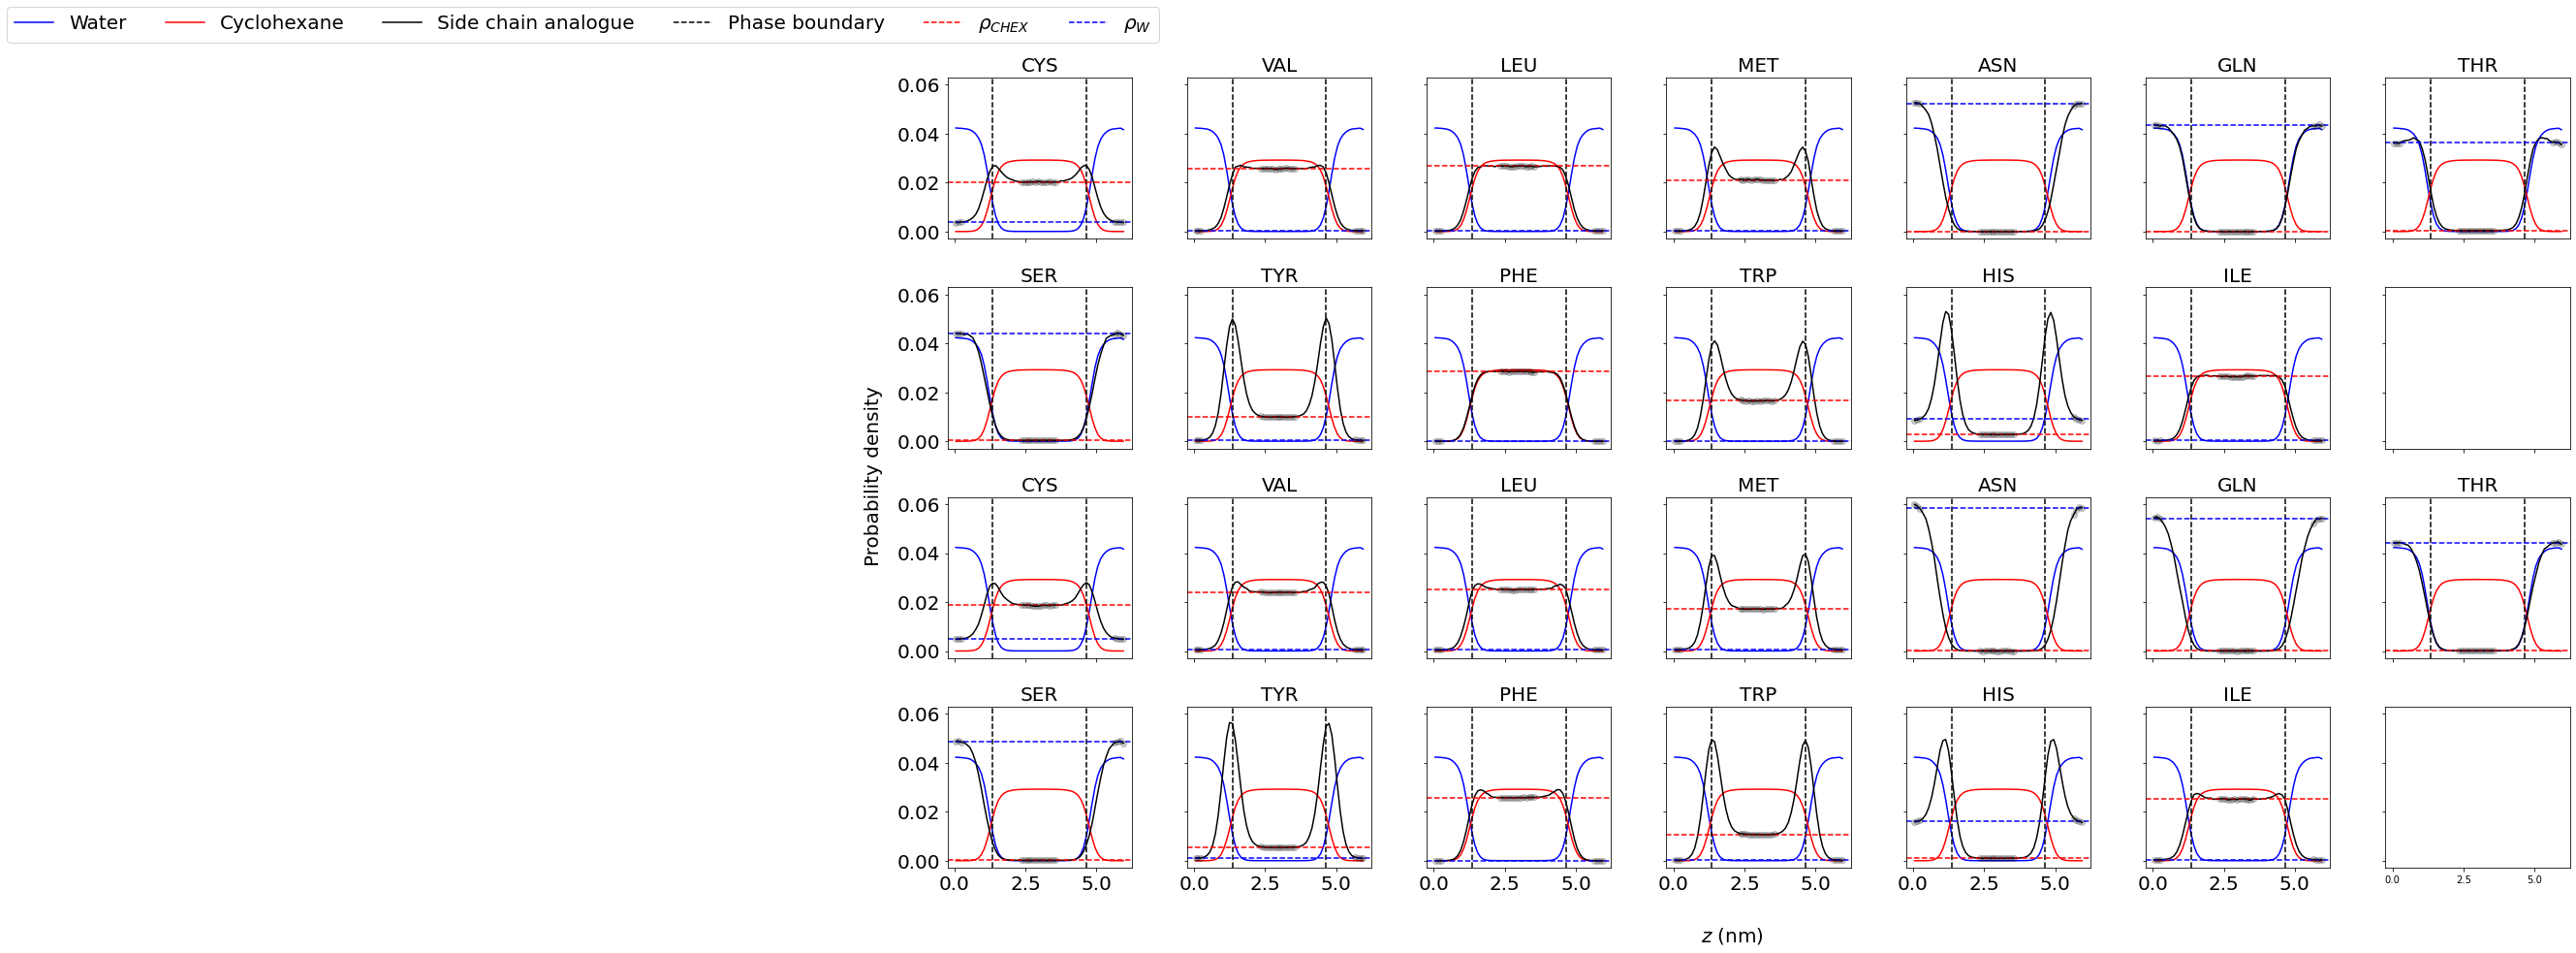

In [32]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=4, ncols=7, sharex=True, sharey=True)    
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.text(0.5, 0.07, '$z$ (nm)', ha='center', va='top', fontsize=20)
fig.text(0.09, 0.5, 'Probability density', ha='center', va='center', fontsize=20, rotation=90)

excluded_boundary_nidx = 10

partitioning_deltaGs = {}
n=0
is_nextline = False
for aa in amino_acids:
    print(aa)
    if n>6:
        is_nextline = True
        n=0
    if is_nextline == True:
        k=1
    else:
        k=0

    for ffmod in ffmods:

        #Get densities along z and average over simulations frames
        densities_z = load_pickle(f'data/CHEX_W_SC_density_z_{aa}_{ffmod}.pkl')
        z = densities_z['z'][:-1]
        z/=10.0
        CHEX_W_SC_densities = densities_z['density']
        CHEX_density_avg = np.average(CHEX_W_SC_densities[0], axis=0)
        W_density_avg = np.average(CHEX_W_SC_densities[1], axis=0)
        SC_density_avg = np.average(CHEX_W_SC_densities[2], axis=0)

        #Remove the final point from the arrays (this gets messed up in the slab alignment density calculation)
        CHEX_density_avg = CHEX_density_avg[:-1]
        W_density_avg = W_density_avg[:-1]
        SC_density_avg = SC_density_avg[:-1]

        #Normalize densities
        CHEX_density_avg/=np.sum(CHEX_density_avg)
        W_density_avg/=np.sum(W_density_avg)
        SC_density_avg/=np.sum(SC_density_avg)

        #Get indeces of the boundaries for the CHEX phase
        idx_CHEX = np.where(CHEX_density_avg>W_density_avg)[0]
        idx_CHEX_start = idx_CHEX[0]
        idx_CHEX_end = idx_CHEX[-1]

        #Get the densities of SC analogue in the CHEX and W phase
        SC_density_avg_CHEX = SC_density_avg[idx_CHEX_start+excluded_boundary_nidx:idx_CHEX_end-excluded_boundary_nidx]
        z_SC_CHEX = z[idx_CHEX_start+excluded_boundary_nidx:idx_CHEX_end-excluded_boundary_nidx]
        SC_density_avg_W = np.concatenate((SC_density_avg[:idx_CHEX_start-excluded_boundary_nidx], SC_density_avg[idx_CHEX_end+excluded_boundary_nidx:]))
        z_SC_W = np.concatenate((z[:idx_CHEX_start-excluded_boundary_nidx], z[idx_CHEX_end+excluded_boundary_nidx:]))

        #Get deltaG based on densities
        deltaG = R*T*np.log((np.average(SC_density_avg_CHEX))/(np.average(SC_density_avg_W)))
        partitioning_deltaGs[f'{aa}_{ffmod}'] = deltaG
                
        #Plot normalized densities
        ax[k,n].set_title(aa, fontsize=20)
        ax[k,n].plot(z, W_density_avg, label='Water', c='blue')
        ax[k,n].plot(z, CHEX_density_avg, label='Cyclohexane', c='red')
        ax[k,n].plot(z, SC_density_avg, label='Side chain analogue', c='black')
        ax[k,n].axvline(z[idx_CHEX_start], c='black', ls='--', label='Phase boundary')
        ax[k,n].axvline(z[idx_CHEX_end], c='black', ls='--')
        ax[k,n].axhline(np.average(SC_density_avg_W), c='blue', ls='--', label='$ρ_{W}$')
        ax[k,n].axhline(np.average(SC_density_avg_CHEX), c='red', ls='--', label='$ρ_{CHEX}$')

        ax[k,n].plot(z_SC_CHEX, SC_density_avg_CHEX, 'o', c='black', alpha=0.2)
        ax[k,n].plot(z_SC_W, SC_density_avg_W, 'o', c='black', alpha=0.2)
        
        ax[k,n].tick_params(axis='both', which='major', labelsize=20)
        ax[k,n].set_xticks(np.arange(0.0,6.0,2.5))

        k+=2
    n+=1

ax[0,0].legend(fontsize=20, ncol=6, bbox_to_anchor=(1.2, 1.5))

save_pickle('partitioning_deltaGs_densities_excludeboundary.pkl', partitioning_deltaGs)

fig.savefig("../figures/density_vs_z_sidechainanalogues.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../figures/density_vs_z_sidechainanalogues.png", bbox_inches='tight', pad_inches=1, dpi=400)

In [33]:
partitioning_deltaGs = load_pickle('partitioning_deltaGs_densities_excludeboundary.pkl')

deltaG_Unmodified_vs_aa = []
deltaG_PW_vs_aa = []
deltaG_expt_vs_aa = []
deltaG_Unmodified_vs_aa_Martini3_paper = []
deltaG_Martini3_paper_vs_aa_Martini3_paper = []
deltaG_expt_vs_aa_Martini3_paper = []

for aa in amino_acids:
    deltaG_Unmodified_vs_aa.append(partitioning_deltaGs[f'{aa}_Unmodified'])
    deltaG_PW_vs_aa.append(partitioning_deltaGs[f'{aa}_PW'])
    deltaG_expt_vs_aa.append(expt_deltaGs[aa])
    
    if aa in deltaG_Martini3_paper.keys():
        deltaG_Unmodified_vs_aa_Martini3_paper.append(partitioning_deltaGs[f'{aa}_Unmodified'])
        deltaG_Martini3_paper_vs_aa_Martini3_paper.append(deltaG_Martini3_paper[aa])
        deltaG_expt_vs_aa_Martini3_paper.append(expt_deltaGs[aa])
        
deltaG_Unmodified_vs_aa = np.array(deltaG_Unmodified_vs_aa)
deltaG_PW_vs_aa = np.array(deltaG_PW_vs_aa)
deltaG_expt_vs_aa = np.array(deltaG_expt_vs_aa)
deltaG_Unmodified_vs_aa_Martini3_paper = np.array(deltaG_Unmodified_vs_aa_Martini3_paper)
deltaG_Martini3_paper_vs_aa_Martini3_paper = np.array(deltaG_Martini3_paper_vs_aa_Martini3_paper)
deltaG_expt_vs_aa_Martini3_paper = np.array(deltaG_expt_vs_aa_Martini3_paper)

In [34]:
def pearsonoutput(x,y):
    return stats.pearsonr(x,y)[0]

pearson_Unmodified, pval_pearson = stats.pearsonr(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa), pearsonoutput, vectorized=False, paired=True)    
pearson_err_Unmodified = bootstrap_result.standard_error

pearson_PW, pval_pearson = stats.pearsonr(deltaG_expt_vs_aa, deltaG_PW_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_PW_vs_aa), pearsonoutput, vectorized=False, paired=True)    
pearson_err_PW = bootstrap_result.standard_error

print(pearson_Unmodified, pearson_err_Unmodified)
print(pearson_PW, pearson_err_PW)

0.916776770420994 0.041924588652808834
0.9402360187528762 0.02794614383704602


In [35]:
def rmsdoutput(expt_data, sim_data):
    return np.sqrt(np.average(np.square(sim_data-expt_data)))

rmsd_Unmodified = rmsdoutput(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa), rmsdoutput, vectorized=False, paired=True)    
rmsd_err_Unmodified = bootstrap_result.standard_error

rmsd_PW = rmsdoutput(deltaG_expt_vs_aa, deltaG_PW_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_PW_vs_aa), rmsdoutput, vectorized=False, paired=True)    
rmsd_err_PW = bootstrap_result.standard_error

print(rmsd_Unmodified, rmsd_err_Unmodified)
print(rmsd_PW, rmsd_err_PW)

8.02152920985065 1.3864273551732
6.820570987823488 1.2644854260003087


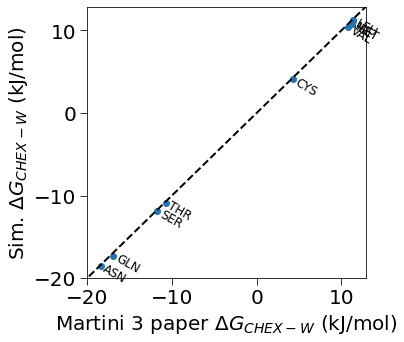

In [36]:
#Check with single beads from Martini 3 paper
fig = plt.figure(figsize=(5,5))

plt.plot(deltaG_Martini3_paper_vs_aa_Martini3_paper, deltaG_Unmodified_vs_aa_Martini3_paper, 'o')

i=0
for aa in amino_acids:
    if aa in deltaG_Martini3_paper.keys():
        plt.text(deltaG_Martini3_paper_vs_aa_Martini3_paper[i]+0.01, deltaG_Unmodified_vs_aa_Martini3_paper[i]-2.0, aa, fontsize=12, rotation=-30)
        i+=1
plt.plot([-100,100],[-100,100],'--',linewidth=2,color='black')

axis_max = np.amax(np.concatenate((deltaG_Unmodified_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper)))
axis_min = np.amin(np.concatenate((deltaG_Unmodified_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper)))
plt.xlim(axis_min-1.5, axis_max+1.5)
plt.ylim(axis_min-1.5, axis_max+1.5)

plt.xlabel('Martini 3 paper $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.ylabel('Sim. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.tick_params(color='black', direction='out', length=7, labelsize=20)

fig.savefig("../figures/partitioning_dGsim_vs_Martini3paper.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../figures/partitioning_dGsim_vs_Martini3paper.png", bbox_inches='tight', pad_inches=1, dpi=400)

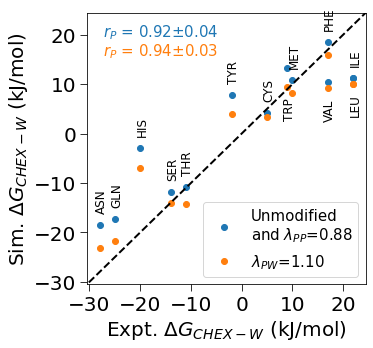

In [37]:
#Plot comparison with experimental deltaG

colors_pltdefault = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(5,5))

plt.plot(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, 'o', label='Unmodified\nand $λ_{{PP}}$=0.88', c=colors_pltdefault[0])
plt.plot(deltaG_expt_vs_aa, deltaG_PW_vs_aa, 'o', label='$λ_{{PW}}$=1.10', c=colors_pltdefault[1])
#plt.plot(deltaG_expt_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper, 'o', c='green')

for i,aa in enumerate(amino_acids):
    
    if aa in ['TRP', 'VAL', 'LEU']:
        plt.text(deltaG_expt_vs_aa[i]-0.9, deltaG_PW_vs_aa[i]-6.0, aa, fontsize=12, rotation=90)
    else:
        plt.text(deltaG_expt_vs_aa[i]-0.9, deltaG_Unmodified_vs_aa[i]+3.0, aa, fontsize=12, rotation=90)
    #plt.text(deltaG_expt_vs_aa[i]+0.05, #deltaG_PW_vs_aa[i]-3.0, aa, fontsize=12, rotation=-30)
    
plt.plot([-100,100],[-100,100],'--',linewidth=2,color='black')

axis_max = np.amax(np.concatenate((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, deltaG_PW_vs_aa)))
axis_min = np.amin(np.concatenate((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, deltaG_PW_vs_aa)))
plt.xlim(axis_min-2.5, axis_max+2.5)
plt.ylim(axis_min-2.5, axis_max+2.5)

plt.legend(fontsize=15, loc='lower right')
plt.text(0.17, 0.76, f'$r_{{P}}$ = {pearson_Unmodified:.2f}±{pearson_err_Unmodified:.2f}\n', fontsize=15, c=colors_pltdefault[0], transform=fig.transFigure)
plt.text(0.17, 0.76, f'$r_{{P}}$ = {pearson_PW:.2f}±{pearson_err_PW:.2f}', fontsize=15, c=colors_pltdefault[1], transform=fig.transFigure)

plt.xticks(np.arange(-30, 25, 10))
plt.yticks(np.arange(-30, 25, 10))

plt.xlabel('Expt. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.ylabel('Sim. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.tick_params(color='black', direction='out', length=7, labelsize=20)

fig.savefig("../figures/partitioning_dGsim_vs_exp.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../figures/partitioning_dGsim_vs_exp.png", bbox_inches='tight', pad_inches=1, dpi=400)